# SLT-CE-5: Pairwise Clustering

<p style="background-color:#adebad;"> 
<b>NOTE</b>: We would like to remind you, that we strongly recommend use environment from environment.yml in this coding exercise repo. Otherwise, we reserve the right to deduct points for non-working code if you worked in a different environment incompatible with the provided one.
</p>

In this coding exercise you will apply pairwise clustering for proximity data and you will see how to use the mean-field approximation (MFA) approach with the EM-algorithm to get a labeling for a data object encoded by similarity and dissimilarity matrices. You will also be able to implement modifications of the EM-scheme to obtain embeddings into an Euclidean space.

<b> References: </b>

[1] T. Hoffman, JM Buhmann. Pairwise Data Clustering by Deterministic Annealing, 1996: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.9812&rep=rep1&type=pdf 

Optionally, the following resources could be helpful:

[2] Lecture 7. Pairwise clustering: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture07.pdf

[3] Lecture script (previous version). Chapter 3.2: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf

[4] Lecture 4. Determenistic Annealing: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture04.pdf

[5] Lecture 8. Mean-field approximation: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture08.pdf

<h2 style="background-color:#f0b375;"> Setup </h2>

In [ ]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import sys
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

#Please use in all section except 5.5 where you have to use random seeds
np.random.seed(111)

<h2 style="background-color:#f0b375;"> Data </h2>

## ProDom Data

ProDom is a comprehensive set of protein domain families [6]. A ProDom subset of 2604 protein domain sequences from the ProDom set was selected by [7]. These are chosen based on a high similarity to at least one sequence contained in the first four folds of the SCOP database. The pairwise structural alignments are computed [7]. Each SCOP sequence belongs to a group, as labeled by the experts [8]. The same four classes are assigned here.

<b> References: </b>

[6] F. Corpet, F. Servant, J. Gouzy and D. Kahn, ProDom and ProDom-CG: tools for protein domain analysis and whole genome comparisons, Nucleid Acids Res., vol. 28, 267-269, 2000.

[7] V. Roth, J. Laub, J.M. Buhmann, and K.-R. Mueller, Going metric: Denoising pairwise data, Advances in Neural Information Processing Systems, 841-856, MIT Press, 2003.

[8] A.G. Murzin, S.E. Brenner, T. Hubbard and C. Chothia, SCOP: a structural classification of proteins database for the investigation of sequences and structures, Journal of Molecular Biology, vol. 247, 536-540, 1995.


Download link: http://prtools.org/disdatasets/index.html#ProDom

In [ ]:
prodom = {"input": loadmat("prodom.mat")}
# After some reverse-engineering:
prodom["similarity"] = np.array(prodom["input"]["s"])[0,0][0]
prodom["labels"] =np.array(prodom["input"]["s"])[0,0][2].flatten()

## Protein Data

The protein data are provided as a 213x213 dissimilarity matrix comparing the protein sequences based on the concept of an evolutionary distance. It was used for classification in [9] and for clustering in [10]. There are four classes of globins: heterogeneous globin (G), hemoglobin-A (HA), hemoglobin-B (HB) and myoglobin (M).

<b> References: </b>

[9] T. Graepel, R. Herbrich, P. Bollmann-Sdorra, K. Obermayer, Classification on pairwise proximity data. In Advances in Neural Information System Processing vol. 11, 438-444, 1999.

[10] T. Denoeux, T. and M.-H. Masson, EVCLUS: Evidential clustering of proximity data. IEEE Transations on Systems, Man and Cybernetics, vol. 34, 95-109, 2004.

Download link (use The PRTools version of Protein): http://prtools.org/disdatasets/index.html#Protein

In [ ]:
protein = {"input": loadmat("protein.mat")}
protein["dissimilarity"] = np.array(protein["input"]["d"])[0,0][0]
protein["labels"] =np.array(protein["input"]["d"])[0,0][2].flatten()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems (4.0.1-4.0.9) in this section to get a pass on this exercise. </span>
</h2>

In this section, you have to give a description of the pairwise clustering approach based on deterministic annealing and mean-field approximation. Then you have to implement it, as described in Algorithm II in reference [1].


<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>


<p style="background-color:#adebad;">
    1. Implement the function <b>plot_pairwise()</b> according to its docstring. <br> 
    Hint: Use <b>matplotlib.pyplot.matshow()</b> to visualize matricies, <b>matplotlib.pyplot.axhspan(),matplotlib.pyplot.axvspan()</b> to add horizontal and vertical rectangles to the plot. If you would like to use <b>np.argsortm</b> use it with flag kind='stable: <b>np.argsort(labels,kind='stable')</b> 
in this case NumPy uses Timsort algorithm to sort indexes. It is stable algorithm which does not change the order of elements with equal keys.
</p>

In [ ]:
def plot_pairwise(data, labels, cmap="binary", alpha=0.33):
    """Plot (dis-)similarity data
    
    Args:
        data (np.ndarray): Symmetric (dis-)similarity array (n_samples, n_samples)
        labels (np.array): Cluster label array  (n_samples,)
        cmap (str): Color Map for (dis-)similarity values. Please use matplotlib colormaps. See here for details: 
        https://matplotlib.org/tutorials/colors/colormaps.html
        alpha (float): Opacity of cluster overlay, between 0 and 1
        
    Shows:
        Image plot of (dis-)similarity matrix, overlaid with transparent blocks,
        which indicate the clusters contained in labels.
        Note: Permute the data according to the sorting of the labels.
        
    Prints:
        Minimum, Maximum and Median of (dis-)similarity values
        Warning, if (dis-)similarity matrix is not symmetric
        
    Returns:
        This is void function. No return required.
    """
   
    #Please add your code here

In [ ]:
#Example how output should looks like after the following command
plot_pairwise(prodom["similarity"], prodom["labels"])

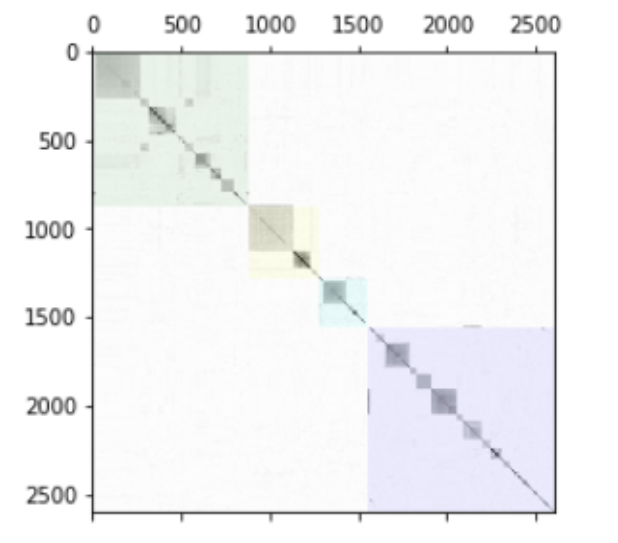

<p style="background-color:#adebad;">
    2. Demonstrate your implementation of <b> plot_pairwise() </b> below.
</p>

In [ ]:
plot_pairwise(protein["dissimilarity"], protein["labels"])

<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>

<p style="background-color:#adebad;">
Read reference [1] and answer the following questions:
</p>
<p style="background-color:#adebad;">
3. Provide a description of general comcept of EM algorithm (not presented in the paper) with main formulas. <br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
4. Why it is not possible to apply EM-scheme for central clustering (algorithm I in [1]) to the case of pairwise clustering? <br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
5. Provide a description of idea mean-field approximation (as KL divergency minimization problem) with main formulas. How does mean field approximaiton approach help to solve problem from the previous question?<br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
6. Provide a description of EM algorithm for pairwise clustering for the case if we have proximity data (algorithm II in [1]). <br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">   
7. Implement the <b>fit_predict()</b> method without embedding (Algorithm II in [1]) for the template <b>class PairwiseClustering</b>, according to its docstring. You can add more class methods if necessary <br>
</p>

In [ ]:
class PairwiseClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for PairwiseClustering (PC)
    
    Attributes:
        M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
        centroids (np.ndarray): Embedding centroids (n_clusters, n_components), used only if embed is True.
        embeddings (np.ndarray): Embeddings of input samples (n_samples, n_components),
                                 used only if embed is True.
    Parameters:
        n_clusters (int): Maximum number of clusters.
        random_state (int): Random seed.
        embed (bool): Indicator, if data should be clustered and embedded simultaneously (algorithm III),
                      or not (algorithm II).
        n_components (int): Dimension of embedding space, used only if embed is True
    """
    
    def __init__(self, n_clusters=4, random_state=1, embed=False, n_components=2, T=1, T_f=0.0001, eps=1e-4, rate=0.5, eps_embed=0.05):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embed = embed
        self.n_components = n_components
        self.T = T
        self.T_f = T_f
        self.eps = eps
        self.rate = rate
        self.M = None
        self.eps_embed = eps_embed
        # Add more parameters, if necessary.
    
    def fit_predict(self, X):
        """Compute PC for dissimilarity matrix X
        
        Compute cluster assignments. If embed is True, also compute embeddings/centroids.
         
        Args:
            X (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
        
        Returns:
            C (np.ndarray): Assignments (n_samples,). 
            This is MAP estimation obtained from matrix M in accordance with notation from reference [1]. 
        """
        np.random.seed(self.random_state)
        
        
        if self.embed == False:
            #Algorithm II from [1] should be implemented here (this is part of the Section 4.0)
            raise NotImplementedError

        if self.embed == True:
            #Algorithm III from [1] should be implemented here (this is part of the Section 6.0)
            raise NotImplementedError

    
    
    def cost(self, D, M):
        """Compute the costs of the clustering solution M for dissimilarity D.
        
        The costs refer to the pairwise clustering costs in eq. (16) of reference [1].
        
        Args:
            D (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
            M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
            
        Returns:
            cost (float): Costs of current clustering
        """
        
        #Please add your code here
                
        return cost

<p style="background-color:#adebad;">
8. Create an instance of your Pairwise Clustering (PC) class, then fit and predict the Protein data. <br>
9. Record the execution time.
</p>

In [ ]:
#Please add your code here

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this (4.5.1-4.5.5) and previous sections to get a grade of 4.5 </span>
</h2>

In this section, you have to compare pairwise clustering with another clustering approach, that also works with proximity data, in terms of different metrics.

<p style="background-color:#adebad;">
1. Read https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering and shortly recap the idea of spectral clustering.
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
2. Predict the Protein data with sklearn.SpectralClustering. <br>
3. Record the execution time. <br>
</p>

In [ ]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

<p style="background-color:#adebad;">
4. Complete the function <b>compare_clusterings()</b> and use it to compare the spectral and the pairwise clustering methods. <br>
Use the following metrics to compare clustering:
</p>
<ul style="background-color:#adebad;"> 
<li> V-measure cluster labeling given a ground truth. </li>
<li> Normalized Mutual Information between two clusterings. </li>
<li> Homogeneity metric of a cluster labeling given a ground truth. </li>
<li> The Fowlkes-Mallows score </li>
<li> Rand index adjusted for chance. </li>
<li> Adjusted Mutual Information between two clusterings. </li>
</ul>
<p style="background-color:#adebad;">
Hint: use <b>sklearn.metrics.v_measure_score(),sklearn.metrics.normalized_mutual_info_score(), sklearn.metrics.homogeneity_score(), sklearn.metrics.fowlkes_mallows_score(), sklearn.metrics.completeness_score(), sklearn.metrics.adjusted_rand_score(), sklearn.metrics.adjusted_mutual_info_score()</b>. You can also find explanations and examples there: scikit-learn.org
</p>

In [ ]:
def compare_clusterings(labels_true, **labels_pred):
    """Show a summary of different clustering metrics
    
    Args:
        labels_true (array): Ground-truth cluster labels
    
    Note:
        Each kwarg should be an array with predicted labels
    """
    
    n_pred = len(labels_pred)
    
    scores = []
    for name in dir(skl.metrics.cluster):
        score = getattr(skl.metrics.cluster, name)
        try:
            score(labels_true=[0], labels_pred=[0]) # Check if score takes the right arguments
            if "score" not in score.__name__:
                raise TypeError
            if score.__name__ == "v_measure_score":
                raise TypeError
            # Add other scores here
        
        
        except TypeError:
            continue
        else:
            scores.append(score)
    
    for key, val in labels_pred.items():
        raise NotImplementedError
    
    #Please add your code here
    
    return
    

<p style="background-color:#adebad;">
    5. Demonstrate your implementation of <b>compare_clusterings()</b>. See example of how the output should look like below. You should produce one plot. Hint: use <b>matplotlib.pyplot.barh(), matplotlib.pyplot.xticks(), matplotlib.pyplot.yticks()</b> to get horizontal histogram for different metrics as shown below.

</p>

In [ ]:
#Example how output sould looks like after the following command
_ = compare_clusterings(labels_true=protein["labels"],
                        SpectralClustering=labels_spectral,
                        GroundTruth=protein["labels"])

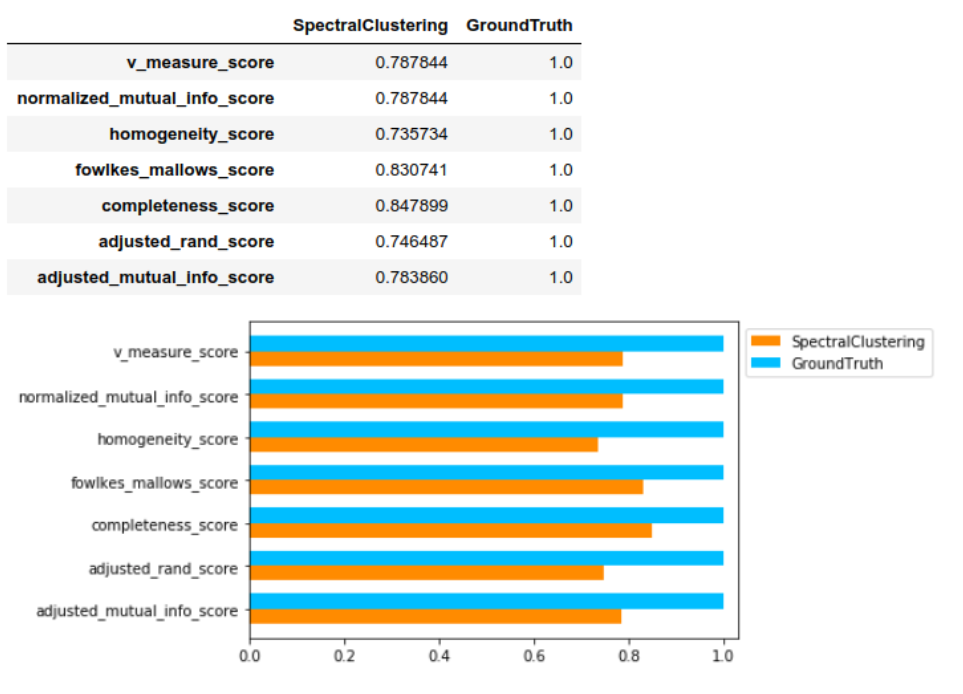

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this (5.0.1-5.0.5) and previous sections to get a grade of 5.0 </span>
</h2>

In this section, you have to investigate the quality of clustering depending on various transformations from similarity data to dissimilarity data and compare results, in terms of different metrics.

<p style="background-color:#adebad;">
    As PairwiseClustering takes dissimilarities as input, we need to transform the similarity data from <b>Prodom</b> accordingly.<br>
    1. Run <b>fit_predict()</b> with all the transformations and parameters below. Run compare_clusterings for each set of parameter values for your <b>PairwiseClustering</b> algorithm. <br>
    2. Produce output of <b>compare_clusterings()</b> for tranformation families below. You should get 3 plots: 1st transformation family comparison, 2nd transformation family comparison, then comparison between of the best transformations of every tranformation family.<br>
<b>NOTE</b>: By best transformation here and further in the notebook is meant the transformation that leads to a maximum average score of scores above for pairwise clustering.
</p>

In [ ]:
#Transformationion family 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 1
# D = ((max(S) - S) / (max(S) - min(S))) ** 2
# D = np.exp(((max(S) - S) / (max(S) - min(S))))

#Please add your code here

In [ ]:
#Transformationion family 2
# D = (max(S) / (1 + S - min(S))) ** 1
# D = (max(S) / (1 + S - min(S))) ** 0.5
# D = np.log((max(S) / (1 + S - min(S))))

#Please add your code here

<p style="background-color:#adebad;">
3. Provide description of another reasonable transformation from similarity to dissimilarity and explain your choice. <br>
<b>NOTE</b>: By reasonable transformation, it is meant some transformation that allows mapping given dissimilarity values to similarity ones in a meaningful way: higher similarity value should correspond to smaller dissimilarity values.
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
4. Implement your transformation. <br>
5. Compare your transformation using <b>compare_clusterings()</b> with the best from task 4.0.2. You should get one plot. <br>
</p>

In [ ]:
#Please add your code here

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this (5.5.1-5.5.6) and previous sections to get a grade of 5.5 </span>
</h2>

In this section, you have to implement and calculate cost function and investigate the stability of pairwise clustering in terms of obtained values of clustering cost function, providing experiments for different random seeds and numer of clusters.

<p style="background-color:#adebad;">
1. Implement the cost function of the <b>PairwiseClustering class</b>. <br>
2. Compute cost function for <b>Protein</b> data. <br>
3. Calculate execution time. <br>
</p>

In [ ]:
#Please add your code here

<p style="background-color:#adebad;">
4. Re-run <b>fit_predict()</b> with 10 different random seeds and plot the distribution of clustering costs as shown in Figure 1 of reference [1]. <br>
5. Visualize the histograms of obtained cost functions.You should get 2 histograms; one for <b>Prodom</b> and the other for <b>Protein</b> data. Hint: use <b>matplotlib.plot.hist()</b> to plot histograms of cost functions.
</p>

<p style="background-color:#adebad;">
<b>NOTE:</b> For ProDom data use best option from section 5.0 to transform similiarities to dissimiliraties. 
</p>

In [ ]:
# Please use Problem 5.0 to transform similarities for ProDom data
# data = [protein,prodom]
# other parameters are default

# Please add your code here

<p style="background-color:#adebad;">
6. Perform the experiment for all the settings listed below, and visualize the results properly. You should get 4 histograms; one for each different number of clusters. <br>
</p>

In [ ]:
# n_clusters = [2, 4, 6, 8]
# data = protein
# other parameters are default

#Please add your code here

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems (6.0.1-6.0.5) in this and previous sections to get a grade of 6.0 </span>
</h2>



In this section, you have to implement an EM-like procedure to obtain data embeddings in Euclidean space, while visualizing these clusters on a 2d plane.

<p style="background-color:#adebad;">
1. Provide a description of the EM-like procedure for pairwise clustering in case we want to get emeddings (algorithm III in reference [1]). <br>
</p>

In [ ]:
#Provide your answer here

<p style="background-color:#adebad;">
2.  Implement Algorithm III in [1], which explains how to compute an embedding within the EM-like procedure. In code <b>fit_predict()</b>: the <b>embed == True</b> part.<br>
3. Predict clustering for <b>Protein</b> data.<br>
4. Calculate execution time.<br>
</p>

In [ ]:
np.random.seed(111)
#PCE = PairwiseClustering(embed=True,...)

#Please add your code here

<p style="background-color:#adebad;">
5. Cluster the Protein data and properly visualize the embedding for <b>n_components=2</b>. Hint: <b>use matplotlib.pyplot.scatter()</b> to plot clusters on 2d plane using different colors for different clusters.
</p>

In [ ]:
#Please add your code here

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.